# spline-utils - basic usage

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import spline_utils as spl
from spline_utils.encoder import SplineEncoder
from scipy.interpolate import splev

# Comparison with `scipy.interpolate.splev`

 * results are consistent with splev
 * performance around four times slower for spline evaluation (but try out 5,000 or so basis functions for a surprise)
 * performance better for encoding unless there are very few basis functions
 
For most regression applications, I don't think the differences in performance matter, though.

In [7]:
def patsy_like(x, knots, order=3):
    """using scipy.interpolate.splev in a loop over basis functions like patsy does"""
    knots = spl.quantile_knots(x, n_knots, order=order)    
    s = knots.size - (order + 1)
    res = np.empty((x.size, s))
    coef = np.zeros(s)
    for i in range(s):
        coef[i] = 1
        res[:, i] = splev(x, (knots, coef, order))
        coef[i] = 0
    return res

In [16]:
order = 3
n_knots = 20
x = np.random.uniform(size=100000)
knots = spl.quantile_knots(x, n_knots, order=order)
coef = np.random.rand(knots.size)

In [17]:
deriv = 0
%time expected = splev(x, (knots, coef, order))
%time actual = spl.spline_eval(x, knots, coef, order=order)
assert np.allclose(actual, expected)

CPU times: user 45.9 ms, sys: 1.72 ms, total: 47.6 ms
Wall time: 48 ms
CPU times: user 25.2 ms, sys: 2.34 ms, total: 27.5 ms
Wall time: 26.3 ms


In [14]:
%time expected = patsy_like(x, n_knots, order=order)
%time actual = SplineEncoder(knots=n_knots, order=order).fit_transform(x)
assert np.allclose(actual, expected)

CPU times: user 164 ms, sys: 7.82 ms, total: 172 ms
Wall time: 171 ms
CPU times: user 37 ms, sys: 10.6 ms, total: 47.6 ms
Wall time: 47.4 ms


# Penalty terms

Penalty matrix on square of integral of second derivative leaves offset and linear terms unaffected.

These can be separately regularized by using the optional projectors onto the null-space of the curvature penalty (constant/linear terms).

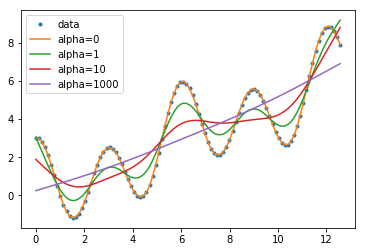

In [48]:
x = np.linspace(0, 4 * np.pi, 100)
y = .5 * x + np.cos(x) + 2. * np.cos(2.1 * x)

encoder = SplineEncoder(knots=20)
X = encoder.fit_transform(x)

penalty = spl.get_cubic_spline_penalty(encoder.knots_)
XTX = X.T.dot(X)
XTy = y.dot(X)

fig, ax = plt.subplots()

ax.plot(x, y, '.', label='data')

for alpha in [0, 1., 10., 1000.]:
    beta = np.linalg.solve(XTX + alpha * penalty, XTy)
    ax.plot(x, X.dot(beta), label='alpha=%.0f' % alpha)
ax.legend()